# Исследование объявлений о продаже квартир

**Цель исследования:** определить факторы рыночной стоимости объектов недвижимости.

**Инструменты.** Акцент уделяется на предобработку данных: заполнение пропусков, выявление неявных дубликатов и анализ аномалий (*диаграмма размаха*). Определение зависимости цены от различных факторов с помощью диаграммы *scatter и линейных графиков*.

**Библиотеки:** seaborn, matplotlib, plotly

**Описание данных:** данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

Датасет **real_estate_data.csv** содержит колонки:
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

**Содержание**
1. [Открытие данных](#open)
2. [Предобработка данных](#preprocessing)
3. [Исследовательский анализ данных](#analysis)
    * 3.1. [Параметры объектов](#parameters)
        * 3.1.1. [общая площадь](#square)
        * 3.1.2. [жилая площадь](#living_area)
        * 3.1.3. [площадь кухни](#kitchen_area)
        * 3.1.4. [цена объекта](#last_price)
        * 3.1.5. [количество комнат](#rooms)
        * 3.1.6. [высота потолков](#ceiling_height)
        * 3.1.7. [этаж квартиры](#floor)
        * 3.1.8. [тип этажа квартиры](#floor_type)
        * 3.1.9. [общее количество этажей в доме](#floors_total)
        * 3.1.10. [расстояние до центра города в метрах](#cityCenters_nearest)
        * 3.1.11. [расстояние до ближайшего аэропорта](#airports_nearest)
        * 3.1.12. [расстояние до ближайшего парка](#parks_nearest)
        * 3.1.13. [день и месяц публикации объявления](#weekday)
        * 3.1.14. [Динамика продажи квартиры](#days_exposition)
    * 3.2. [Факторы, влияющие на стоимость квартиры](#factors)
        * 3.2.1. [Зависимость цены от общей площади](#last_price_total_area)
        * 3.2.2. [Зависимость цены от жилой площади](#last_price_living_area)
        * 3.2.3. [Зависимость цены от площади кухни](#last_price_kitchen_area)
        * 3.2.4. [Зависимость цены от количества комнат](#last_price_rooms)
        * 3.2.5. [Зависимость цены от этажа, на котором расположена квартира](#last_price_floor_type)
        * 3.2.6. [Зависимость цены от даты размещения (день недели, месяц, год)](#last_price_weekday)
    * 3.3. [Средняя стоимость одного квадратного метра в разных населенных пунктах](#price_for_m2)
    * 3.4. [Средняя стоимость одного квадратного метра в Санкт-Петербурге в зависимости от расположения квартиры](#price_for_m2_spb)
4. [Общий вывод](#conclusion)

## 1. Открытие данных<a class="anchor" id="open"></a>

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn
import plotly.express as px
from plotly import graph_objects as go

!pip install missingno
import missingno as msno

In [2]:
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()

total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  ...  \
0            2.70          16.0         51.0      8          NaN  ...   
1             NaN          11.0         18.6      1          NaN  ...   
2             NaN           5.0         34.3      4          NaN  ...   
3             NaN          14.0          NaN      9          NaN  ...   
4            3.03          14.0         32.0     13          NaN  ...   

   kitchen_area  balcony    locality_name  airports_nearest  \
0          25.0      NaN  Санкт-Петербург           18863.0   
1          11.0      2.0   посёлок Шушары           12817.0   
2           8.3      0.0  Санкт-Петербург           21741.0   
3           NaN      0.0  Санкт-Петербург           28098.0   
4          41.0      NaN  Санкт-Петербург           31856.0   

  cityCenters_nearest  parks_around3000  parks_nearest  ponds_around3000  \
0             16028.0               1.0          482.0               2.0   
1             18603.0               0.0            NaN               0.0   
2             13933.0               1.0           90.0               2.0   
3              6800.0               2.0           84.0               3.0   
4              8098.0               2.0          112.0               1.0   

   ponds_nearest  days_exposition  
0          755.0              NaN  
1            NaN             81.0  
2          574.0            558.0  
3          234.0            424.0  
4           48.0            121.0  

[5 rows x 22 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

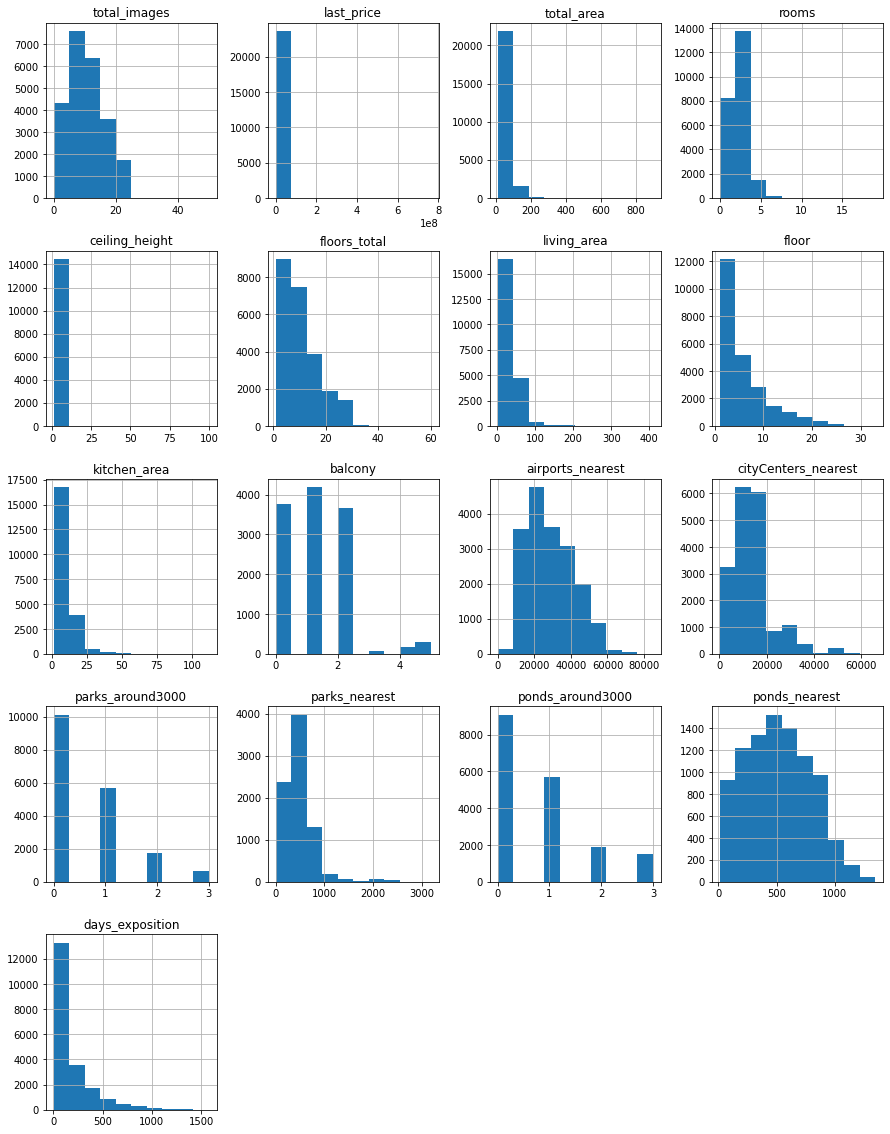

In [5]:
data.hist(figsize=(15,20))
plt.title('Гистограммы. Общая информация')
plt.show()

**Вывод:**
Стали известны значения, по которым стоит проводить анализ данных. По первоначальным гистограммам можно сказать, что есть большой разброс данных в last_price, total_area, rooms, ceiling_height, living_area, days_exposition

## 2. Предобработка данных<a class="anchor" id="preprocessing"></a>

### 2.1. Пропуски

In [6]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Более наглядно пропуски можно посмотреть на матрице:

<AxesSubplot:>

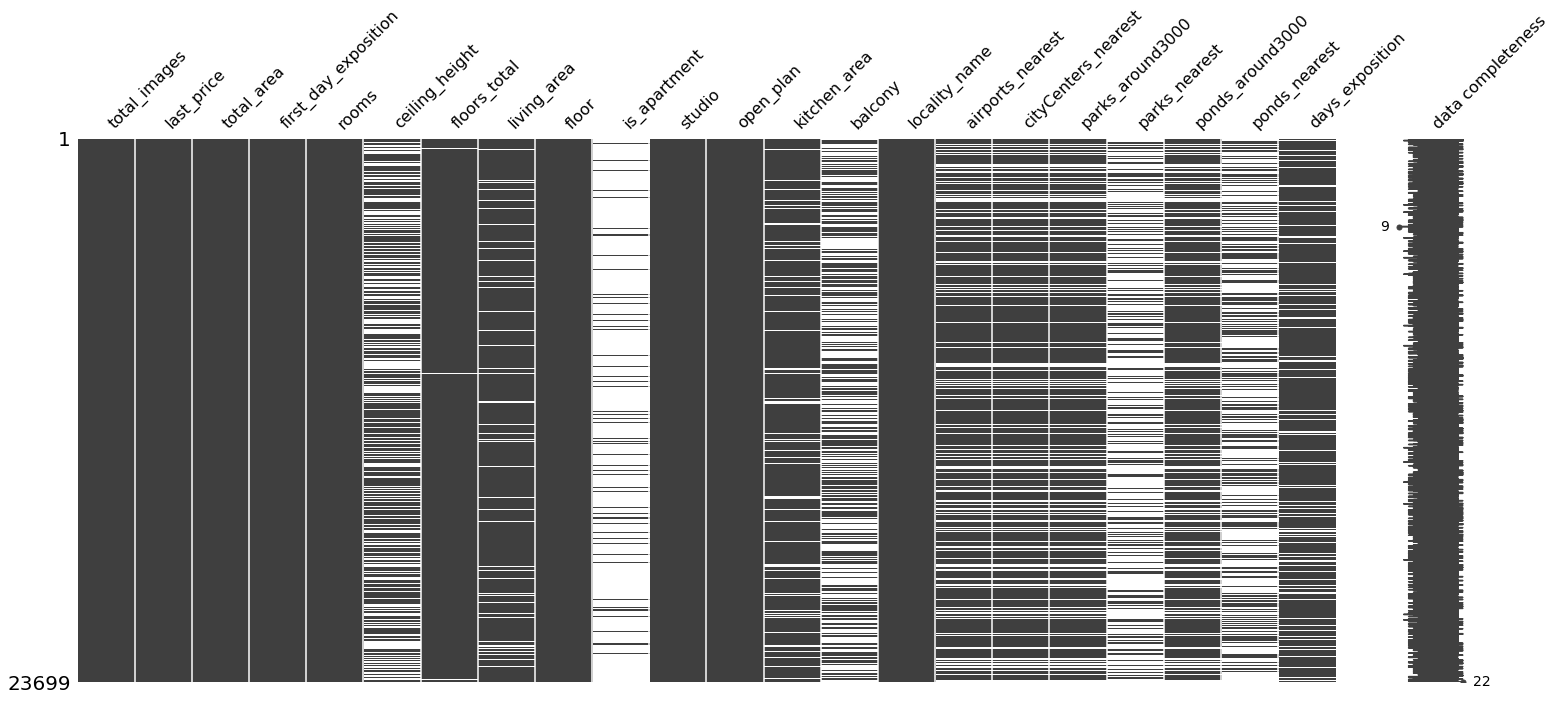

In [7]:
msno.matrix(data, labels=True)

**Пропуски содержатся в:** 

* ceiling_height - можно заменить медианой в зависимости от расстояния от центра
* airports_nearest, cityCenters_nearest, parks_nearest - можно заменить медианой по населенному пункту
* balcony - скорее всего говорит об отсутсвии балкона в квартире, т.е. заменить на 0
* is_apartment - отсутсвие данных скорее всего говорит, что это не апартаменты, т.е. заменить на False
* living_area - как как отношение total_area*ratio, где ratio = известное living_area/total_area
* kitchen_area - как разница между total_area и living_area 
* days_exposition - заполнить никак нельзя; floors_total - не следует заменять медианой, поскольку исказятся значения

**Удалить столбцы:**
* locality_name - незначительное количество пропусков, так как это важные данные и заменить их ничем нельзя, то столбец придется удалить - это не повлияет на общий профиль
* parks_around3000, ponds_around3000, ponds_nearest, total_images, open_plan - никак не влияют на общий профиль и цену квартир

In [8]:
#удалим пропуски в название местности
data = data.dropna(subset = ['locality_name'])

In [9]:
#удалим ненужные столбцы
data = data.drop(labels=['parks_around3000', 'ponds_around3000', 'ponds_nearest', 'total_images', 'open_plan'], axis=1)

In [10]:
#заполняем пропуски в наличии балконов
data['balcony'] = data['balcony'].fillna(0)

#проверка
data['balcony'].isna().sum()

0

In [11]:
#отношение жилой площади к общей
data['ratio'] = data['living_area']/data['total_area']

#заполняем пропуски этого отношения с группировкой по комнатам
for room in data['rooms'].unique():
    median = data.loc[data['rooms'] == room, 'ratio'].median()
    data.loc[(data['rooms'] == room) & (data['ratio'].isna()), 'ratio'] = median
    
#заполняем пропуски, где пропущены значения living_area, считаем как отношение total_area*ratio
data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(), 'total_area'] * data.loc[data['living_area'].isna(), 'ratio']

#проверка
data['living_area'].isna().sum()

0

In [12]:
#заполняем пропуски в kitchen_area как разница между total_area и living_area
data.loc[data['kitchen_area'].isna(), 'kitchen_area'] = data.loc[data['kitchen_area'].isna(), 'total_area'] - data.loc[data['kitchen_area'].isna(), 'living_area']

#проверка
data['kitchen_area'].isna().sum()

0

In [13]:
#посмотрим уникальные названия местности
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [14]:
#избавимся от дубликатов в названиях местности
name = ['посёлок', 'городской', 'поселок', 'городского типа', 'деревня', 'садовое товарищество', 'село', 'садоводческое некоммерческое товарищество', 'при железнодорожной станции', 'коттеджный']
for element in name:
        data['locality_name'] = data['locality_name'].str.replace(element, '').str.strip()
data['locality_name'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Фёдоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодёжное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

In [15]:
# заполним пропуски в parks_around3000, parks_nearest, ponds_around3000, ponds_nearest, 
# airports_nearest, cityCenters_nearest, floors_total как медиана этого значения по населенному пункту
for area in data['locality_name'].unique():
    #заполним пропуски в парках
    data.loc[(data['locality_name'] == area) & (data['parks_nearest'].isna()), 'parks_nearest'] = \
    data.loc[(data['locality_name'] == area), 'parks_nearest'].median()
    
    #заполним пропуски для аэропорта
    data.loc[(data['locality_name'] == area) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == area), 'airports_nearest'].median()
    
    #заполним пропуски для центра
    data.loc[(data['locality_name'] == area) & (data['cityCenters_nearest'].isna()), 'cityCenters_nearest'] = \
    data.loc[(data['locality_name'] == area), 'cityCenters_nearest'].median()
    

#заполним оставшиеся пропуски в этих значниях как медиана по всем населнным пунктам
data.loc[data['parks_nearest'].isna(), 'parks_nearest'] = data['parks_nearest'].median()
data.loc[data['airports_nearest'].isna(), 'airports_nearest'] = data['airports_nearest'].median()
data.loc[data['cityCenters_nearest'].isna(), 'cityCenters_nearest'] = data['cityCenters_nearest'].median()

#проверка
data.isna().sum()

last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9160
floors_total               85
living_area                 0
floor                       0
is_apartment            20890
studio                      0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest            0
cityCenters_nearest         0
parks_nearest               0
days_exposition          3180
ratio                       0
dtype: int64

In [16]:
#найдем минимальное и максимальное значение cityCenters_nearest для создания функции
print(data['cityCenters_nearest'].min())
print(data['cityCenters_nearest'].max())

181.0
65968.0


In [17]:
#создадим функцию, которая будет определять, насколько близко находится квартира к центру, 
#где Категория 1 - близко, Категория 4 - далеко
def categorize_area(distance):
    try:
        if 0 <= distance <= 10000:
            return 'Категория 1'
        elif 10001 <= distance <= 30000:
            return 'Категория 2'
        elif 30001 <= distance <= 500000:
            return 'Категория 3'
        elif distance >= 500001:
            return 'Категория 4'
    except:
        pass

In [18]:
#применим функцию
data['category_of_area'] = data['cityCenters_nearest'].apply(categorize_area)
data.head()

last_price  total_area first_day_exposition  rooms  ceiling_height  \
0  13000000.0       108.0  2019-03-07T00:00:00      3            2.70   
1   3350000.0        40.4  2018-12-04T00:00:00      1             NaN   
2   5196000.0        56.0  2015-08-20T00:00:00      2             NaN   
3  64900000.0       159.0  2015-07-24T00:00:00      3             NaN   
4  10000000.0       100.0  2018-06-19T00:00:00      2            3.03   

   floors_total  living_area  floor is_apartment  studio  kitchen_area  \
0          16.0       51.000      8          NaN   False        25.000   
1          11.0       18.600      1          NaN   False        11.000   
2           5.0       34.300      4          NaN   False         8.300   
3          14.0      100.435      9          NaN   False        58.565   
4          14.0       32.000     13          NaN   False        41.000   

   balcony    locality_name  airports_nearest  cityCenters_nearest  \
0      0.0  Санкт-Петербург           18863.0              16028.0   
1      2.0           Шушары           12817.0              18603.0   
2      0.0  Санкт-Петербург           21741.0              13933.0   
3      0.0  Санкт-Петербург           28098.0               6800.0   
4      0.0  Санкт-Петербург           31856.0               8098.0   

   parks_nearest  days_exposition     ratio category_of_area  
0          482.0              NaN  0.472222      Категория 2  
1          460.0             81.0  0.460396      Категория 2  
2           90.0            558.0  0.612500      Категория 2  
3           84.0            424.0  0.631667      Категория 1  
4          112.0            121.0  0.320000      Категория 1

In [19]:
#заполним пропуски в ceiling_height как медиана с группировкой по километрам до центра
for area in data['category_of_area'].unique():
    data.loc[(data['category_of_area'] == area) & (data['ceiling_height'].isna()), 'ceiling_height'] = \
    data.loc[(data['category_of_area'] == area), 'ceiling_height'].median()
data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = data['ceiling_height'].median()

#проверка
data['ceiling_height'].isna().sum()

0

In [20]:
#заполним пропуски в is_apartment

data.loc[data['is_apartment'].isna(), 'is_apartment'] = False

#проверка
data.isna().sum()

last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              85
living_area                0
floor                      0
is_apartment               0
studio                     0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_nearest              0
days_exposition         3180
ratio                      0
category_of_area           0
dtype: int64

**Вывод:** Остались пропуски в days_exposition и в floors_total, которые никак нельзя заменить логически. 

### 2.2. Типы данных

In [21]:
# поменяем типы данных

data['rooms'] = data['rooms'].astype('int8')
data['balcony'] = data['balcony'].astype('int8')
data['floor'] = data['floor'].astype('int8')

data['is_apartment'] = data['is_apartment'].astype('bool')

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT%H:%M:%S')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23650 entries, 0 to 23698
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   last_price            23650 non-null  float64       
 1   total_area            23650 non-null  float64       
 2   first_day_exposition  23650 non-null  datetime64[ns]
 3   rooms                 23650 non-null  int8          
 4   ceiling_height        23650 non-null  float64       
 5   floors_total          23565 non-null  float64       
 6   living_area           23650 non-null  float64       
 7   floor                 23650 non-null  int8          
 8   is_apartment          23650 non-null  bool          
 9   studio                23650 non-null  bool          
 10  kitchen_area          23650 non-null  float64       
 11  balcony               23650 non-null  int8          
 12  locality_name         23650 non-null  object        
 13  airports_nearest

**Вывод:** Удалив несколько столбцов и изменив тип данных на int8, память уменьшилась с *memory usage: 3.7+ MB* до *memory usage: 2.8+ MB*. Также изменили тип данных, где используется дата, для удобного дальнейшего анализа.

### 2.3. Аномалии

In [22]:
data.describe()

last_price    total_area         rooms  ceiling_height  floors_total  \
count  2.365000e+04  23650.000000  23650.000000    23650.000000  23565.000000   
mean   6.541127e+06     60.329069      2.070106        2.733906     10.675875   
std    1.089640e+07     35.661808      1.078620        0.993491      6.594823   
min    1.219000e+04     12.000000      0.000000        1.000000      1.000000   
25%    3.400000e+06     40.000000      1.000000        2.600000      5.000000   
50%    4.650000e+06     52.000000      2.000000        2.600000      9.000000   
75%    6.799000e+06     69.700000      3.000000        2.770000     16.000000   
max    7.630000e+08    900.000000     19.000000      100.000000     60.000000   

        living_area         floor  kitchen_area       balcony  \
count  23650.000000  23650.000000  23650.000000  23650.000000   
mean      34.681866      5.893277     11.739752      0.591712   
std       22.843491      4.883317      8.229041      0.959662   
min        2.000000      1.000000      0.000000      0.000000   
25%       18.700000      2.000000      7.200000      0.000000   
50%       30.000000      4.000000      9.800000      0.000000   
75%       42.318750      8.000000     13.000000      1.000000   
max      430.133948     33.000000    255.702684      5.000000   

       airports_nearest  cityCenters_nearest  parks_nearest  days_exposition  \
count      23650.000000         23650.000000   23650.000000     20470.000000   
mean       29071.212643         14221.275645     471.917019       180.753200   
std        11697.072771          7682.753628     203.703786       219.777916   
min            0.000000           181.000000       1.000000         1.000000   
25%        21160.000000         10939.000000     460.000000        45.000000   
50%        27223.000000         13270.000000     460.000000        95.000000   
75%        35841.000000         15743.000000     460.000000       231.000000   
max        84869.000000         65968.000000    3190.000000      1580.000000   

              ratio  
count  23650.000000  
mean       0.564903  
std        0.102764  
min        0.021583  
25%        0.491339  
50%        0.571429  
75%        0.633484  
max        1.000000

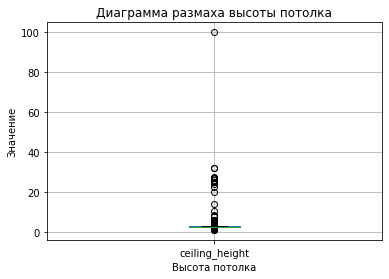

In [23]:
#построим диаграмму размаха для высоты потолка
data.boxplot(column = 'ceiling_height')
plt.xlabel('Высота потолка')
plt.ylabel('Значение')
plt.title('Диаграмма размаха высоты потолка')
plt.show()

In [24]:
#заменим ошибки в записи высоты, поделив значения, которые больше 10 м, на 10.
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] = data.loc[data['ceiling_height'] > 10, 'ceiling_height']/10
print(sorted(data['ceiling_height'].unique().round(1)))

[1.0, 1.0, 1.2, 1.4, 1.8, 2.0, 2.2, 2.2, 2.3, 2.3, 2.3, 2.4, 2.4, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.6, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.7, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.8, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 2.9, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.0, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.1, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.2, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.3, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.4, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.6, 3.7, 3.7, 3.7, 3.7, 3.7, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.8, 3.9, 3.9, 3.9, 3.9, 3.9, 4.0, 4.0, 4.0, 4.1, 4.1, 4.1, 4.2, 4.2, 4.2, 4.2, 4.3, 4.4, 4.4, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.2, 5.3, 5.5, 5.6, 5.8, 6.0, 8.0, 8.3, 10.0]


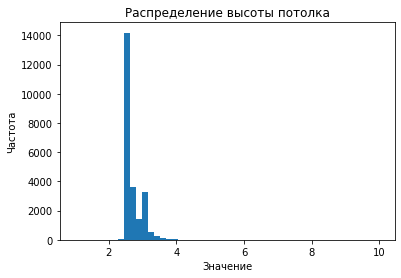

In [25]:
data['ceiling_height'].plot(bins=50, title='ceiling_height', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение высоты потолка')
plt.show()

Минимальной нормой считается высота потолка 2,4 м. Максимум возьмем до 4 м.

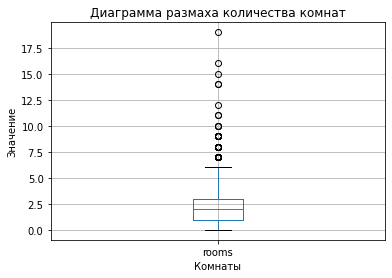

In [26]:
# проверка аномалий в количестве комнат
data.boxplot(column='rooms')
plt.xlabel('Комнаты')
plt.ylabel('Значение')
plt.title('Диаграмма размаха количества комнат')
plt.show()

In [27]:
sorted(data['rooms'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19]

Максимум возьмем по правому усу - 6 комнат.

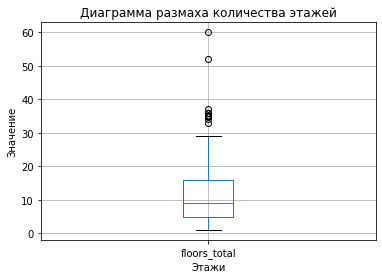

In [28]:
# проверка аномалий в количестве этажей
data.boxplot(column='floors_total')
plt.xlabel('Этажи')
plt.ylabel('Значение')
plt.title('Диаграмма размаха количества этажей')
plt.show()

In [29]:
print(sorted(data['floors_total'].unique()))

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, nan, 28.0, 29.0, 33.0, 34.0, 35.0, 36.0, 37.0, 52.0, 60.0]


Самое высокое жилое здание в Санкт-Петербурге состоит из 37 этажей. Максимум возьмем по правому усу, примерно 29 этаж.

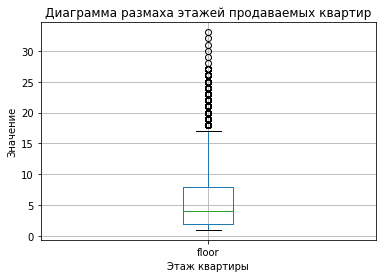

In [30]:
# проверка аномалий в floor
data.boxplot(column = 'floor')
plt.xlabel('Этаж квартиры')
plt.ylabel('Значение')
plt.title('Диаграмма размаха этажей продаваемых квартир')
plt.show()

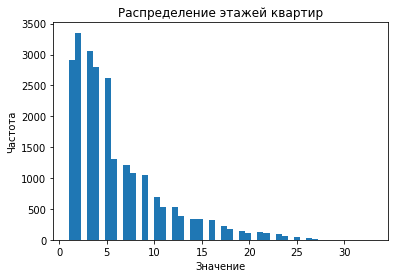

In [31]:
data['floor'].plot(bins=50, title='floor', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение этажей квартир')
plt.show()

In [32]:
data = data.query('2.4 <=ceiling_height <=4 and rooms<=6 and floors_total<=29 and floor<=18')
data.shape[0]

22659

Удалили несколько разбросов в значениях, сократив таблицу на 968 строк (примерно 1%)

### 2.4. Новые столбцы в таблице

In [33]:
#цена одного квадратного метра
data['price_for_m2'] = data['last_price']/data['total_area']

#день недели публикации объявления, где 0 — понедельник, 1 — вторник и так далее)
data['weekday'] = data['first_day_exposition'].dt.weekday

#месяц публикации объявления
data['month'] = pd.DatetimeIndex(data['first_day_exposition']).month

#год публикации объявления
data['year'] = pd.DatetimeIndex(data['first_day_exposition']).year

# создаём категории для населённых пунктов
data['locality_name_category'] = 'Другое'
data.loc[data['locality_name'] == 'Санкт-Петербург', 'locality_name_category'] = 'Санкт-Петербург'

In [34]:
#создаем функцию для категоризации квартиры по этажам
def floor_type(data):
    if data['floor']==1:
        return 'первый'
    elif data['floor']==data['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [35]:
#применим функцию и создадим новый столбец
data['floor_type'] = data.apply(floor_type, axis=1)
data.head()

last_price  total_area first_day_exposition  rooms  ceiling_height  \
0  13000000.0       108.0           2019-03-07      3            2.70   
1   3350000.0        40.4           2018-12-04      1            2.60   
2   5196000.0        56.0           2015-08-20      2            2.60   
3  64900000.0       159.0           2015-07-24      3            3.00   
4  10000000.0       100.0           2018-06-19      2            3.03   

   floors_total  living_area  floor  is_apartment  studio  ...  parks_nearest  \
0          16.0       51.000      8         False   False  ...          482.0   
1          11.0       18.600      1         False   False  ...          460.0   
2           5.0       34.300      4         False   False  ...           90.0   
3          14.0      100.435      9         False   False  ...           84.0   
4          14.0       32.000     13         False   False  ...          112.0   

   days_exposition     ratio  category_of_area   price_for_m2  weekday  month  \
0              NaN  0.472222       Категория 2  120370.370370        3      3   
1             81.0  0.460396       Категория 2   82920.792079        1     12   
2            558.0  0.612500       Категория 2   92785.714286        3      8   
3            424.0  0.631667       Категория 1  408176.100629        4      7   
4            121.0  0.320000       Категория 1  100000.000000        1      6   

   year locality_name_category  floor_type  
0  2019        Санкт-Петербург      другой  
1  2018                 Другое      первый  
2  2015        Санкт-Петербург      другой  
3  2015        Санкт-Петербург      другой  
4  2018        Санкт-Петербург      другой  

[5 rows x 25 columns]

In [36]:
#расстояние до центра города в километрах
data['km'] = data['cityCenters_nearest'] // 1000
data.head()

last_price  total_area first_day_exposition  rooms  ceiling_height  \
0  13000000.0       108.0           2019-03-07      3            2.70   
1   3350000.0        40.4           2018-12-04      1            2.60   
2   5196000.0        56.0           2015-08-20      2            2.60   
3  64900000.0       159.0           2015-07-24      3            3.00   
4  10000000.0       100.0           2018-06-19      2            3.03   

   floors_total  living_area  floor  is_apartment  studio  ...  \
0          16.0       51.000      8         False   False  ...   
1          11.0       18.600      1         False   False  ...   
2           5.0       34.300      4         False   False  ...   
3          14.0      100.435      9         False   False  ...   
4          14.0       32.000     13         False   False  ...   

   days_exposition     ratio category_of_area   price_for_m2  weekday  month  \
0              NaN  0.472222      Категория 2  120370.370370        3      3   
1             81.0  0.460396      Категория 2   82920.792079        1     12   
2            558.0  0.612500      Категория 2   92785.714286        3      8   
3            424.0  0.631667      Категория 1  408176.100629        4      7   
4            121.0  0.320000      Категория 1  100000.000000        1      6   

   year  locality_name_category floor_type    km  
0  2019         Санкт-Петербург     другой  16.0  
1  2018                  Другое     первый  18.0  
2  2015         Санкт-Петербург     другой  13.0  
3  2015         Санкт-Петербург     другой   6.0  
4  2018         Санкт-Петербург     другой   8.0  

[5 rows x 26 columns]

## 3. Исследовательский анализ данных <a class="anchor" id="analysis"></a>

### 3.1. Параметры объектов <a class="anchor" id="parameters"></a>

#### 3.1.1 общая площадь  <a class="anchor" id="total_area"></a>

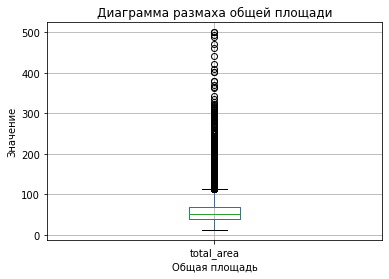

In [37]:
data.boxplot(column='total_area')
plt.xlabel('Общая площадь')
plt.ylabel('Значение')
plt.title('Диаграмма размаха общей площади')
plt.show()

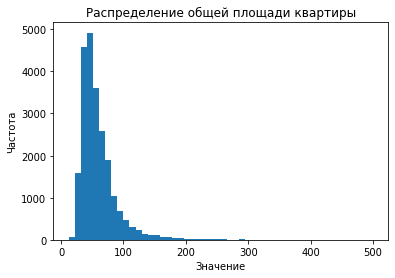

In [38]:
data['total_area'].plot(bins=50, title='total_area', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение общей площади квартиры')
plt.show()

In [39]:
data_total_area = data.query('total_area<220')

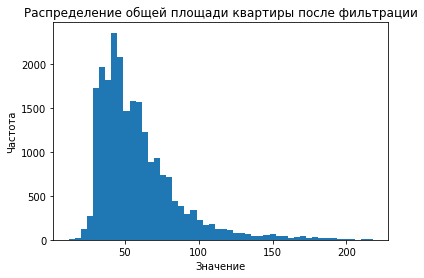

In [40]:
data_total_area['total_area'].plot(bins=50, title='total_area', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение общей площади квартиры после фильтрации')
plt.show()

In [41]:
print(data_total_area['total_area'].mean())
print(data_total_area['total_area'].median())

58.27065566498092
52.0


**Медиана и среднее общей площади схожи, т.е. разбросов в данных незначительное количество. Общая площадь в Санкт-Петербурге и соседних населённых пунктов за несколько лет примерно 58 м²**

Отобразим, как различается общая площадь квартир в разных категориях населённых пунктов. Построим две гистограммы распределения: одну для Санкт-Петербурга, вторую для других населённых пунктов.

In [42]:
# строим гистограммы
fig = px.histogram(data,
                   x='total_area',
                   color='locality_name_category',
                   range_x=[0, 200],
                   title='Распределение общей площади квартиры в зависимости от расположения',
                   nbins=1000,
                   barmode='overlay') # «полупрозрачный» тип отображения столбцов
fig.update_xaxes(title_text='Значение')
fig.update_yaxes(title_text='Частота')
fig.show()

Распределение общей площади что в Санкт-Петербурге, что в других населенных пунктах одинаково.

#### 3.1.2. жилая площадь  <a class="anchor" id="living_area"></a>

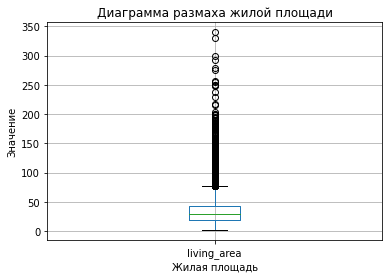

In [43]:
data.boxplot(column='living_area')
plt.xlabel('Жилая площадь')
plt.ylabel('Значение')
plt.title('Диаграмма размаха жилой площади')
plt.show()

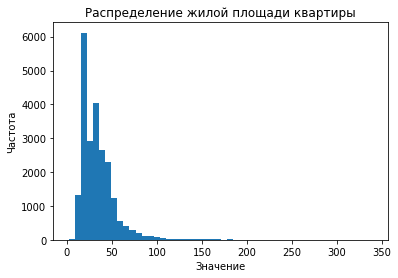

In [44]:
data['living_area'].plot(bins=50, title='living_area', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение жилой площади квартиры')
plt.show()

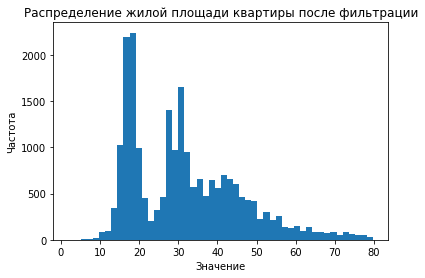

In [45]:
#избавимся от разбросов
data_living_area = data.query('living_area < 80')
data_living_area['living_area'].plot(bins=50, title='living_area', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение жилой площади квартиры после фильтрации')
plt.show()

In [46]:
print(data_living_area['living_area'].mean())
print(data_living_area['living_area'].median())

31.790702700790195
30.0


Прослеживается два пика: примерно 18 (возможно большое количество студий в данных) и 31 м². В общем, медиана и среднее жилой площади схожи, т.е. разбросов в данных незначительное количество. **Жилая площадь в Санкт-Петербурге и соседних населённых пунктов за несколько лет примерно 31 м²**

#### 3.1.3.  площадь кухни <a class="anchor" id="kitchen_area"></a>

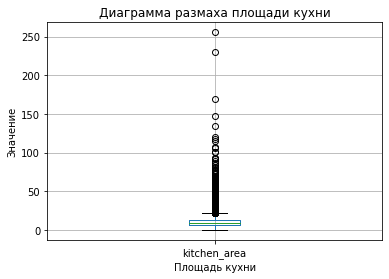

In [47]:
data.boxplot(column='kitchen_area')
plt.xlabel('Площадь кухни')
plt.ylabel('Значение')
plt.title('Диаграмма размаха площади кухни')
plt.show()

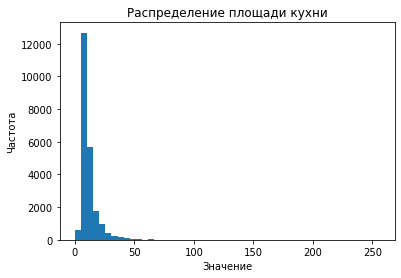

In [48]:
data['kitchen_area'].plot(bins=50, title='kitchen_area', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение площади кухни')
plt.show()

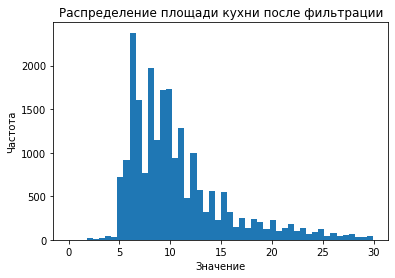

In [49]:
#избавимся от разбросов
data_kitchen_area = data.query('kitchen_area < 30')
data_kitchen_area['kitchen_area'].plot(bins=50, title='kitchen_area', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение площади кухни после фильтрации')
plt.show()

In [50]:
print(data_kitchen_area['kitchen_area'].mean())
print(data_kitchen_area['kitchen_area'].median())

10.61478370564339
9.3


Медиана и среднее площади кухонь схожи, т.е. разбросов в данных незначительное количество. **Площадь кухонь в Санкт-Петербурге и соседних населённых пунктов за несколько лет примерно 10 м²**

#### 3.1.4. цена объекта  <a class="anchor" id="last_price"></a>

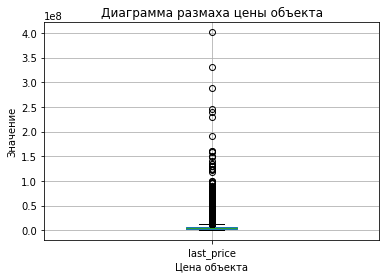

In [51]:
data.boxplot(column='last_price')
plt.xlabel('Цена объекта')
plt.ylabel('Значение')
plt.title('Диаграмма размаха цены объекта')
plt.show()

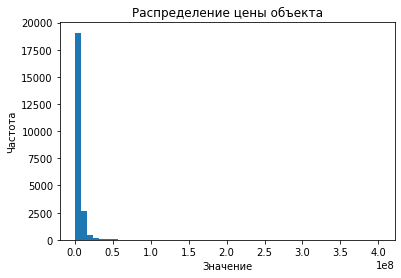

In [52]:
data['last_price'].plot(bins=50, title='last_price', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение цены объекта')
plt.show()

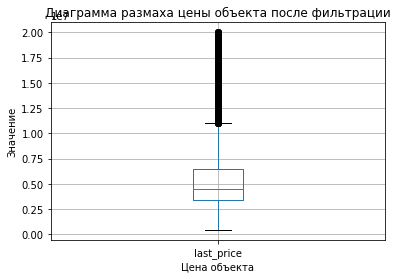

In [53]:
#избавимся от разбросов
data_last_price = data.query('last_price < 20000000')
data_last_price.boxplot(column='last_price')
plt.xlabel('Цена объекта')
plt.ylabel('Значение')
plt.title('Диаграмма размаха цены объекта после фильтрации')
plt.show()

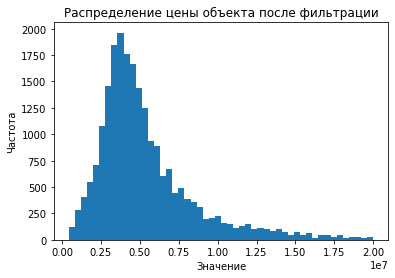

In [54]:
data_last_price['last_price'].plot(bins=50, title='last_price', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение цены объекта после фильтрации')
plt.show()

In [55]:
# во сколько раз сократили данные
data.shape[0]/data_last_price['last_price'].shape[0]

1.028365253698829

In [56]:
print(data_last_price['last_price'].mean())
print(data_last_price['last_price'].median())

5374244.898384315
4500000.0


Первоначально медиана и среднее цены различались почти в 2 раза, то есть разбросов в данных было значительное количество, из-за этого страдал общий профиль. Удалили 1% данных. И стала видна **средняя цена за квартиры в Санкт-Петербурге и ближайших населенных пунктах: примерно 4,5 млн. руб.**

#### 3.1.5. количество комнат <a class="anchor" id="rooms"></a>

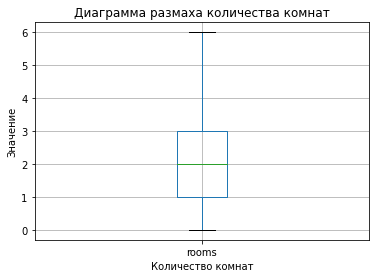

In [57]:
data.boxplot(column='rooms')
plt.xlabel('Количество комнат')
plt.ylabel('Значение')
plt.title('Диаграмма размаха количества комнат')
plt.show()

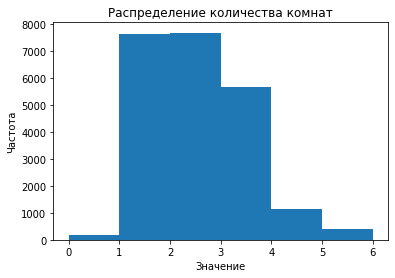

In [58]:
data['rooms'].plot(bins=6, title='rooms', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение количества комнат')
plt.show()

In [59]:
#Количество объявлений в зависимости от числа комнат
data_rooms = pd.DataFrame(data['rooms'].value_counts()).reset_index()

# диаграмму с сегментами
fig = go.Figure(data=[go.Pie(labels=data_rooms['index'],
                             values=data_rooms['rooms'],
                             pull = [0.1, 0])]) # аргумент, который выделит сегмент-лидер на графике
fig.update_layout(title='Число квартир по количеству комнат',
                  width=800,
                  height=600,
                  annotations=[dict(x=1.12,
                                    y=1.05,
                                    text='Количество комнат',
                                    showarrow=False)])
fig.show()

**Чаще всего встречаются квартиры с 2 комнатами.**

#### 3.1.6. высота потолков<a class="anchor" id="ceiling_height"></a>

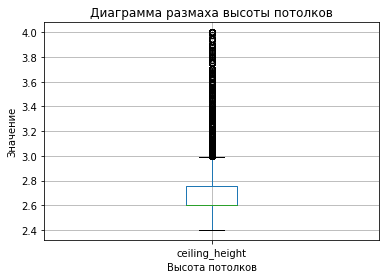

In [60]:
data.boxplot(column='ceiling_height')
plt.xlabel('Высота потолков')
plt.ylabel('Значение')
plt.title('Диаграмма размаха высоты потолков')
plt.show()

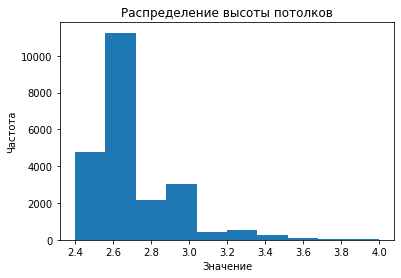

In [61]:
data['ceiling_height'].plot(bins=10, title='ceiling_height', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение высоты потолков')
plt.show()

**Средная высота потолка составляет 2,6 м.**

#### 3.1.7. этаж квартиры<a class="anchor" id="floor"></a>

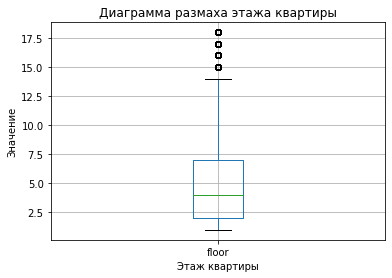

In [62]:
data.boxplot(column='floor')
plt.xlabel('Этаж квартиры')
plt.ylabel('Значение')
plt.title('Диаграмма размаха этажа квартиры')
plt.show()

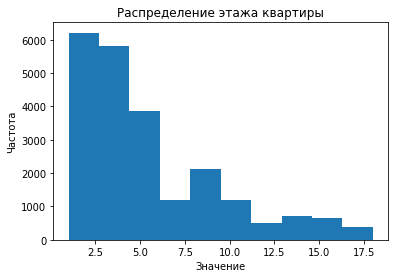

In [63]:
data['floor'].plot(bins=10, title='floor', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение этажа квартиры')
plt.show()

In [64]:
print(data['floor'].mean())
print(data['floor'].median())

5.378392691645704
4.0


**Чаще всего квартиры продаются на 4-5 этажах.**

#### 3.1.8. тип этажа квартиры<a class="anchor" id="floor_type"></a>

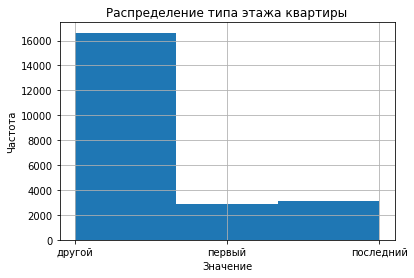

In [65]:
data['floor_type'].hist(bins=3)
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение типа этажа квартиры')
plt.show()

**Меньше всего можно встретить продажу квартир на первом или последнем этаже - спрос на них меньше.**

#### 3.1.9. общее количество этажей в доме<a class="anchor" id="floors_total"></a>

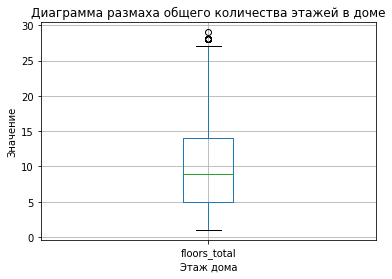

In [66]:
data.boxplot(column='floors_total')
plt.xlabel('Этаж дома')
plt.ylabel('Значение')
plt.title('Диаграмма размаха общего количества этажей в доме')
plt.show()

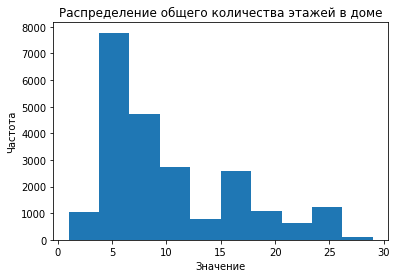

In [67]:
data['floors_total'].plot(bins=10, title='floors_total', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение общего количества этажей в доме')
plt.show()

In [68]:
print(data['floors_total'].mean())
print(data['floors_total'].median())

10.247716139282405
9.0


**В Санкт-Петербурге и его окрестностях чаще всего встречаются дома с 9-10 этажами.**

#### 3.1.10. расстояние до центра города в метрах<a class="anchor" id="cityCenters_nearest"></a>

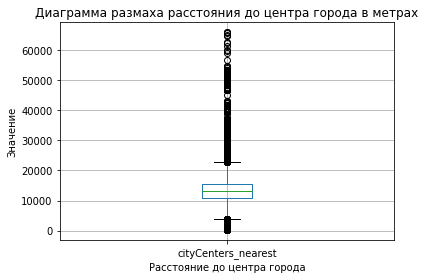

In [69]:
data.boxplot(column='cityCenters_nearest')
plt.xlabel('Расстояние до центра города')
plt.ylabel('Значение')
plt.title('Диаграмма размаха расстояния до центра города в метрах')
plt.show()

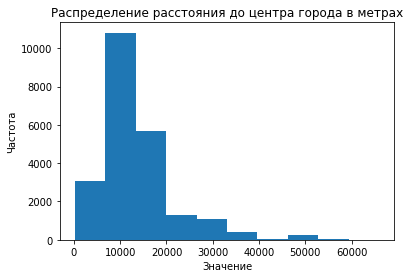

In [70]:
data['cityCenters_nearest'].plot(bins=10, title='cityCenters_nearest', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение расстояния до центра города в метрах')
plt.show()

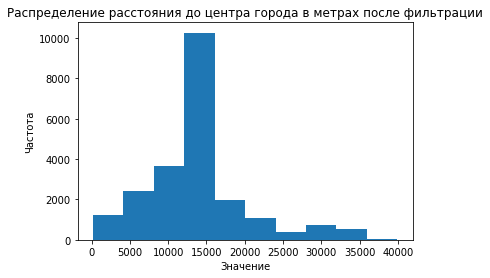

In [71]:
data_cityCenters_nearest = data.query('cityCenters_nearest < 40000')
data_cityCenters_nearest['cityCenters_nearest'].plot(bins=10, title='cityCenters_nearest', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение расстояния до центра города в метрах после фильтрации')
plt.show()

**Больше всего квартир продается недалеко от центра, поскольку они в основном пользуются спросом.**

#### 3.1.11. расстояние до ближайшего аэропорта<a class="anchor" id="airports_nearest"></a>

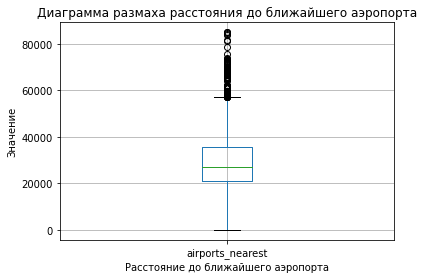

In [72]:
data.boxplot(column='airports_nearest')
plt.xlabel('Расстояние до ближайшего аэропорта')
plt.ylabel('Значение')
plt.title('Диаграмма размаха расстояния до ближайшего аэропорта')
plt.show()

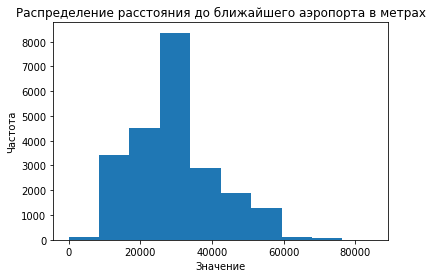

In [73]:
data['airports_nearest'].plot(bins=10, title='airports_nearest', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение расстояния до ближайшего аэропорта в метрах')
plt.show()

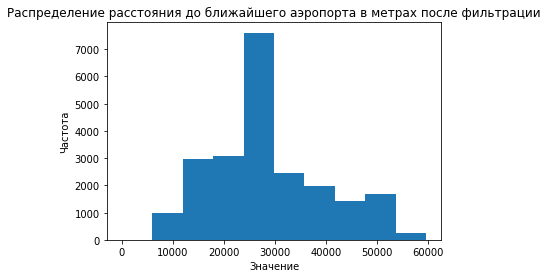

In [74]:
data_airports_nearest = data.query('airports_nearest < 60000')
data_airports_nearest['airports_nearest'].plot(bins=10, title='airports_nearest', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение расстояния до ближайшего аэропорта в метрах после фильтрации')
plt.show()

**Чаще всего квартиры расположены в 25-30 км от аэропорта.**

#### 3.1.12. расстояние до ближайшего парка<a class="anchor" id="parks_nearest"></a>

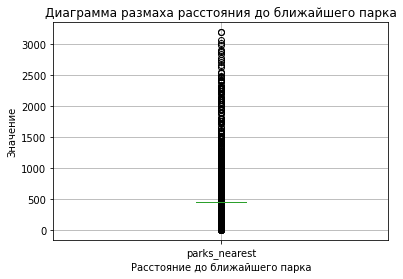

In [75]:
data.boxplot(column='parks_nearest')
plt.xlabel('Расстояние до ближайшего парка')
plt.ylabel('Значение')
plt.title('Диаграмма размаха расстояния до ближайшего парка')
plt.show()

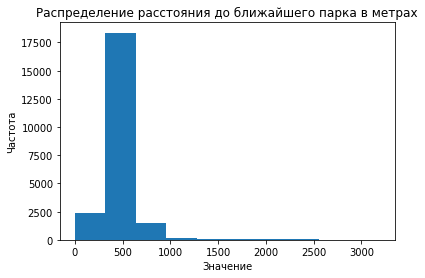

In [76]:
data['parks_nearest'].plot(bins=10, title='parks_nearest', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение расстояния до ближайшего парка в метрах')
plt.show()

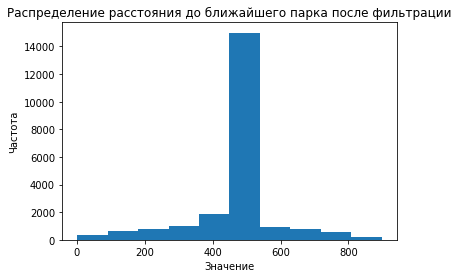

In [77]:
data_parks_nearest = data.query('parks_nearest < 900')
data_parks_nearest['parks_nearest'].plot(bins=10, title='parks_nearest', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение расстояния до ближайшего парка после фильтрации')
plt.show()

**Чаще всего квартиры находятся в 500 м от ближайшего парка - покупатели любят обращать на это внимание.**

#### 3.1.13. день и месяц публикации объявления<a class="anchor" id="weekday"></a>

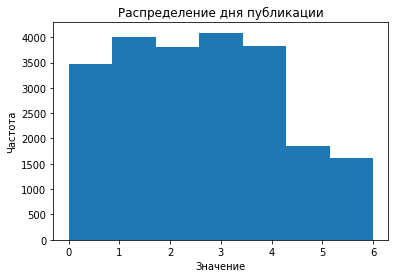

In [78]:
data['weekday'].plot(bins=7, title='weekday', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение дня публикации')
plt.show()

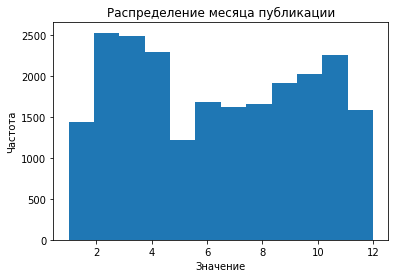

In [79]:
data['month'].plot(bins=12, title='month', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение месяца публикации')
plt.show()

**Чаще всего публикуют новые квартиры по будням. Также наблюдается тенденция, что квартиры имеют спрос с сентября(из-за приезда новых студентов и рабочих в этот период времени) и наблюдается пик весной.**

#### 3.1.14 Динамика продажи квартиры<a class="anchor" id="days_exposition"></a>

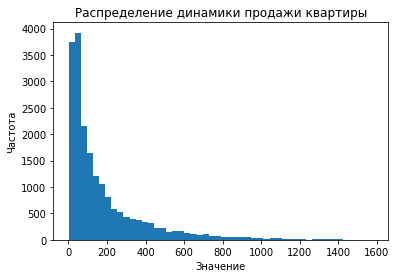

In [80]:
data['days_exposition'].plot(bins=50, title='days_exposition', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение динамики продажи квартиры')
plt.show()

In [81]:
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

print(data['days_exposition'].min())
print(data['days_exposition'].max())

180.42927127985303
95.0
1.0
1580.0


Быстрые продажи - продажи, которые были совершены в течение одного дня после публикации объявления.
Наблюдается большой разброс данных, поскольку медиана и среднее количество дней размещения рекламы отличаются в два раза. Проверим запись с наибольшим количеством дней в объявлении.

In [82]:
data.query('days_exposition == 1580.0')

last_price  total_area first_day_exposition  rooms  ceiling_height  \
18843   3500000.0        48.2           2014-12-15      2             2.5   

       floors_total  living_area  floor  is_apartment  studio  ...  \
18843           5.0         27.4      2         False   False  ...   

       days_exposition     ratio category_of_area  price_for_m2  weekday  \
18843           1580.0  0.568465      Категория 2  72614.107884        0   

       month  year  locality_name_category floor_type    km  
18843     12  2014                  Другое     другой  13.0  

[1 rows x 26 columns]

Все значения для строки 18843 выглядят реальными, за исключением количеством дней размещения рекламы. Один из вариантов причины: продавец забыл убрать на сайте квартиру с продажи и из-за этого среднее значение исказилось. Возможно про это забыли и другие продавцы. Посмотрим диаграмму размаха.

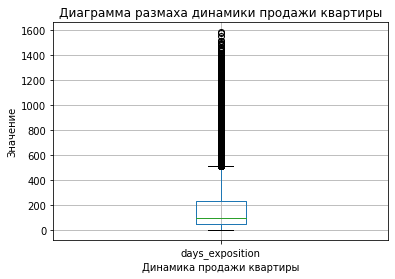

In [83]:
data.boxplot(column='days_exposition')
plt.xlabel('Динамика продажи квартиры')
plt.ylabel('Значение')
plt.title('Диаграмма размаха динамики продажи квартиры')
plt.show()

In [84]:
# возьмем значения days_exposition до 500
data = data.query('days_exposition < 500.0')
print(data['days_exposition'].mean())
print(data['days_exposition'].median())

126.77036375808972
84.0


Разница между средним и медианой уменьшилась и уже выглядит более реальным. Оставим такие данные.

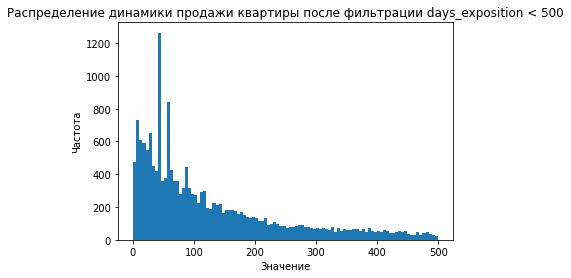

In [85]:
#посмотрим на диаграмму с сокращенными значениями
data['days_exposition'].plot(bins=100, title='days_exposition', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение динамики продажи квартиры после фильтрации days_exposition < 500')
plt.show()

Стали видны пики, но не понятны их причины. Посмотрим более подробно: уменьшим до 100 дней и увеличим количество корзин.

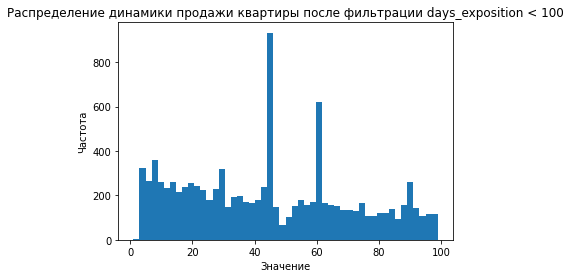

In [86]:
data_days_exposition = data.query('days_exposition < 100')
data_days_exposition['days_exposition'].plot(bins=50, title='days_exposition', kind='hist')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.title('Распределение динамики продажи квартиры после фильтрации days_exposition < 100')
plt.show()

Наблюдаются пики на 30, 45, 60 и 90 дни. Скорее всего это автоматическое закрытие объявлений при условии, что продавец не продлил его - хорошее решения для получения корректных данных.

### 3.2. Факторы, влияющие на стоимость квартиры<a class="anchor" id="factors"></a>

#### 3.2.1 Зависимость цены от общей площади <a class="anchor" id="last_price_total_area"></a>

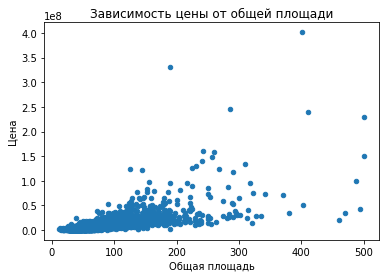

In [87]:
data.plot(x='total_area', y='last_price', kind='scatter')
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от общей площади')
plt.show()

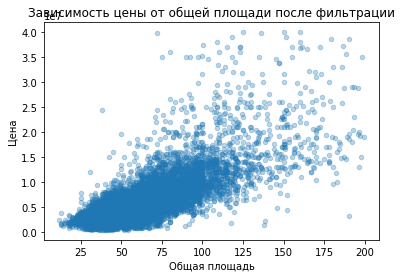

In [88]:
data_total_area_price = data.query('total_area<200 and last_price<40000000')
data_total_area_price.plot(x='total_area', y='last_price', kind='scatter', alpha=0.3)
plt.xlabel('Общая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от общей площади после фильтрации')
plt.show()

**Зависимость цены от общей площади носит прямо пропорциональный характер.**

#### 3.2.2. Зависимость цены от жилой площади<a class="anchor" id="last_price_living_area"></a>

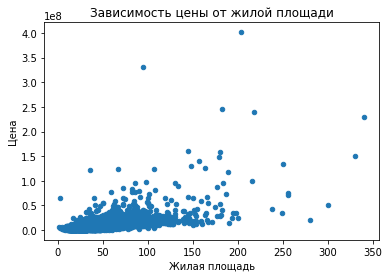

In [89]:
data.plot(x='living_area', y='last_price', kind='scatter')
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от жилой площади')
plt.show()

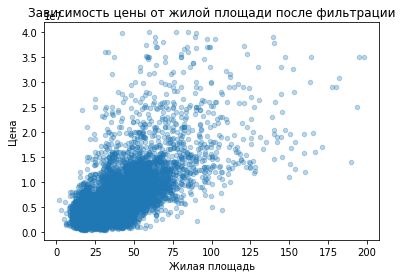

In [90]:
data_living_area_price = data.query('living_area<200 and last_price<40000000')
data_living_area_price.plot(x='living_area', y='last_price', kind='scatter', alpha=0.3)
plt.xlabel('Жилая площадь')
plt.ylabel('Цена')
plt.title('Зависимость цены от жилой площади после фильтрации')
plt.show()

**Зависимость цены от жилой площади носит прямо пропорциональный характер.**

#### 3.2.3. Зависимость цены от площади кухни<a class="anchor" id="last_price_kitchen_area"></a>

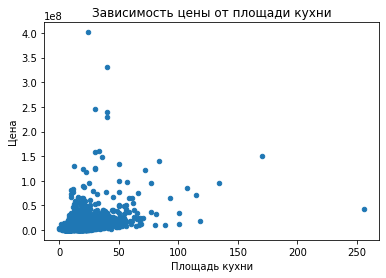

In [91]:
data.plot(x='kitchen_area', y='last_price', kind='scatter')
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('Зависимость цены от площади кухни')
plt.show()

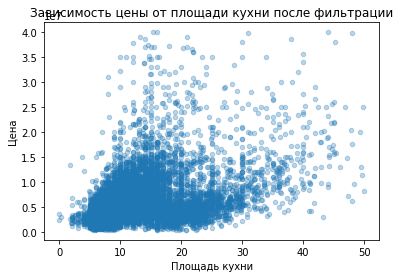

In [92]:
data_kitchen_area_price = data.query('kitchen_area<50 and last_price<40000000')
data_kitchen_area_price.plot(x='kitchen_area', y='last_price', kind='scatter', alpha=0.3, legend=True)
plt.xlabel('Площадь кухни')
plt.ylabel('Цена')
plt.title('Зависимость цены от площади кухни после фильтрации')
plt.show()

**Цена от площади кухни не имеет зависимости.**

#### 3.2.4. Зависимость цены от количества комнат<a class="anchor" id="last_price_rooms"></a>

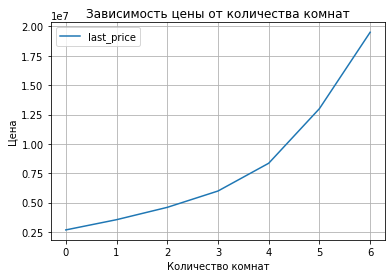

In [93]:
data.pivot_table(index='rooms', values='last_price', aggfunc='median').plot(grid=True)
plt.xlabel('Количество комнат')
plt.ylabel('Цена')
plt.title('Зависимость цены от количества комнат')
plt.show()

**Зависимость цены от количества комнат носит прямо пропорциональный характер.**

#### 3.2.5. Зависимость цены от этажа, на котором расположена квартира<a class="anchor" id="last_price_floor_type"></a>

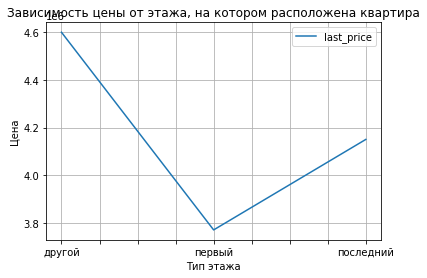

In [94]:
data.pivot_table(index='floor_type', values='last_price', aggfunc = 'median').plot(grid=True)
plt.xlabel('Тип этажа')
plt.ylabel('Цена')
plt.title('Зависимость цены от этажа, на котором расположена квартира')
plt.show()

**Цена зависит от этажа, на котором находится квартира. Так, покупатели предпочитают квартиры не на первом и не на последнем этажах, следовательно, чтобы увеличить спрос на этих квартиры, уменьшают стоимость.**

#### 3.2.6. Зависимость цены от даты размещения (день недели, месяц, год)<a class="anchor" id="last_price_weekday"></a>

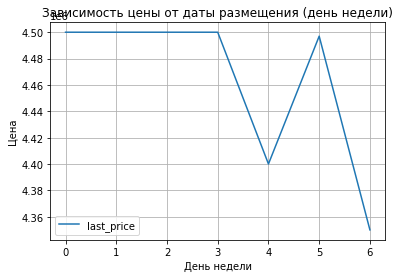

In [95]:
data.pivot_table(index='weekday', values='last_price', aggfunc = 'median').plot(grid=True)
plt.xlabel('День недели')
plt.ylabel('Цена')
plt.title('Зависимость цены от даты размещения (день недели)')
plt.show()

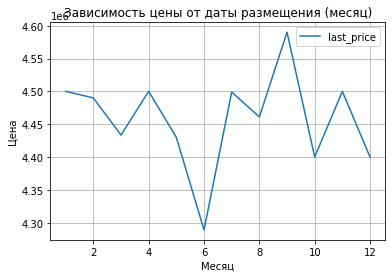

In [96]:
data.pivot_table(index='month', values='last_price', aggfunc = 'median').plot(grid=True)
plt.xlabel('Месяц')
plt.ylabel('Цена')
plt.title('Зависимость цены от даты размещения (месяц)')
plt.show()

**Так как существует спрос на квартиры в апреле и в сентябре, то цены увеличиваются.**

In [97]:
# по годам
# сводная таблица
data_price_time = data.loc[data['year'] != 2014].groupby(['month','year'], as_index=False)[['last_price']].median().round()
# линейный график
fig = px.line(data_price_time,
              x='month',
              y='last_price',
              color='year',
              markers=True)
fig.update_layout(title='Медианная стоимость в зависимости от месяца публикации',
                   xaxis_title='Месяц',
                   yaxis_title='Медианная стоимость')
fig.show()

### 3.3. Средняя стоимость одного квадратного метра в разных населенных пунктах<a class="anchor" id="price_for_m2"></a>

In [98]:
# Лидеры по количеству объявлений
data_loc_count = data.groupby('locality_name')[['locality_name']].count()
# переименуем столбец
data_loc_count.columns = ['total_count']
# отсортируем и оставим пять лидеров
data_loc_count = data_loc_count.sort_values(by='total_count', ascending=False).reset_index().head(6)

print('Санкт-Петербург и другие топ-5 населенных пунктов по количеству объявлений:')
display(data_loc_count)

Санкт-Петербург и другие топ-5 населенных пунктов по количеству объявлений:


locality_name  total_count
0  Санкт-Петербург        11863
1           Мурино          451
2          Кудрово          363
3           Шушары          355
4       Всеволожск          306
5          Колпино          290

In [104]:
# строим столбчатую диаграмму 
fig = px.bar(data_loc_count.sort_values(by='total_count', ascending=True),
             x='total_count',
             y='locality_name',
             text='total_count'
            )
fig.update_layout(title='Санкт-Петербург и другие топ-5 населённых пунктов по количеству квартир',
                   xaxis_title='Количество объявлений',
                   yaxis_title='Населённый пункт')
fig.show()

In [101]:
best_price_for_m2 = data.groupby('locality_name') \
    .agg({'price_for_m2':['count', 'mean']}) \
    .sort_values(by=('price_for_m2','count'), ascending=False)
print('Средняя цена одного квадратного метра в Санкт-Петербурге и в других топ-5 населённых пунктах:')

best_price_for_m2.head(6)

Средняя цена одного квадратного метра в Санкт-Петербурге и в других топ-5 населённых пунктах:


price_for_m2               
                       count           mean
locality_name                              
Санкт-Петербург        11863  110889.029622
Мурино                   451   85669.642090
Кудрово                  363   94679.951304
Шушары                   355   77711.594001
Всеволожск               306   68489.697818
Колпино                  290   74710.045072

In [102]:
high_price_for_m2 = best_price_for_m2['price_for_m2']['mean'].max().round(0)
locality_of_high_price_for_m2 = best_price_for_m2['price_for_m2']['mean'].idxmax()


low_price_for_m2 = best_price_for_m2['price_for_m2']['mean'].min().round(0)
locality_of_low_price_for_m2 = best_price_for_m2['price_for_m2']['mean'].idxmin()

print(f'Самая высокая стоимость квадратного метра в {locality_of_high_price_for_m2}е: {high_price_for_m2}')
print(f'Самая низкая стоимость квадратного метра в {locality_of_low_price_for_m2}: {low_price_for_m2}')

Самая высокая стоимость квадратного метра в Лисий Носе: 113728.0
Самая низкая стоимость квадратного метра в Старополье: 11206.0


### 3.4. Средняя стоимость одного квадратного метра в Санкт-Петербурге в зависимости от расположения квартиры<a class="anchor" id="price_for_m2_spb"></a>

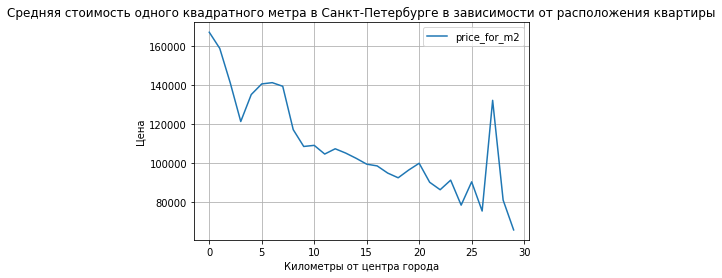

In [103]:
data_km = data.query('locality_name == "Санкт-Петербург"') \
    .pivot_table(index='km', values='price_for_m2') \
    .plot(grid=True)
plt.xlabel('Километры от центра города')
plt.ylabel('Цена')
plt.title('Средняя стоимость одного квадратного метра в Санкт-Петербурге в зависимости от расположения квартиры')
plt.show()

**Наблюдается обратная зависимость цены от увеличения расстояния от центра города. По графику можно сказать, что центр заканчивается примерно на 7 км, поскольку наблюдается резкий спад цены.**

## 4. Общий вывод<a class="anchor" id="conclusion"></a>

1. В данных содержалось большое количество пропусков. 
* Самая вероятная причина: нежелание продавцов заполнять значения для разных характеристик, так как они думают, что это неважные значения для продажи, например высота потолков, жилая площадь (если есть общая площадь) или площадь кухни. 
* Некоторые данные не были заполнены, поскольку предполагали отсутсвие значения, например, наличие балкона.
* Отсутствовали многие картографические данные. Вероятно заполняли адрес не по шаблону, и система не находила его на карте. таким образом, не могла посмотреть ближайшее расстояние.

Однако, многие пропуски удалось заменить медианой по групировке населенного пункта или дальности от центра. Чтобы минимизировать пропуски, стоит рассмотреть заполнение объявления и добавить обязательные поля.

2. Больше всего объявлений за несколько лет было выставлено в Санкт-Петербурге и в Мурино, Кудрово и Шушары, поскольку это ближайшие города-спутники к Санкт-Петербургу. 
Рыночная стоимость квартир носит несколько зависимостей:
* прямо пропорциональный характер: цена-общая площадь; цена-жилая площадь, цена-количество комнат
* обрато пропорциональный характер: цена-расстояние от центра
* наблюдается тенденция спроса квартир в апреле и сентябре, следовательно, идет увеличение стоимости квартир
* цена квартир, которые находятся на первом или последнем этажах, ниже других, поскольку спрос на данные квартиры меньше